In [1]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm


from PIL import Image, ImageDraw
import glob
import os
import matplotlib.pyplot as plt

import numpy as np
import scipy.misc as smp

import json
from datetime import datetime

from operator import add
import re
import time



In [2]:
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error


In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.options.display.max_rows = 4000
from IPython.display import display
pd.options.display.max_columns = None

In [3]:
# include functions 
%run phase02-mask-generation/SugarUtils.py

./tiles/tile-x7620-y7600.png
./geometries/geo-x7620-y7600.geojson
./mask/mask-x7620-y7600.png


In [5]:
# data collection

mask_files = f"./Phase02-DataDelivery/masks/*.png"
mask_images = glob.glob(mask_files)

# get all the x, y positions of tiles from masks file name
xy_pair = []
for mask_img in mask_images:
    mask_list = re.findall(r'\d+', mask_img)
    xy_pair.append( (mask_list[1],mask_list[2]) )

print(len(xy_pair))

# get mask png data
tile_x, tile_y = xy_pair[0][0], xy_pair[0][1]
mask_file_path = f"./Phase02-DataDelivery/masks/mask-x{tile_x}-y{tile_y}.png"
img = Image.open(mask_file_path)
pixels = img.load()

print(img.size)


# why is alpha 255?  alpha range from 0 to 255 (also range from 0 to 1)
# 0 being completely transparent, 255 being completely opaque
# (0,0,0,255) means black

def get_mask_list(pixels):
    mask_list = []

    for x in range(0,512):
        for y in range(0,512):
            if pixels[y,x] == (0,0,0,255):
                mask_list.append((y,x))
    return mask_list

def get_timeseries_image_paths(tile_x, tile_y, band):
    path = f"./Phase02-DataDelivery/sugarcanetiles/{tile_x}-{tile_y}-{band}*.png"
    images = glob.glob(path)
    return images


# need to sort the band_img list
# sort the image path according to timeseries

def get_image_path_dict(band_img):
    image_path_dict = {}
    for bi in band_img:
        timestr = bi[-14:][:10]
        t = datetime.strptime(timestr, '%Y-%m-%d')
        image_path_dict[t] = bi
    return image_path_dict


tile_x = xy_pair[0][0]
tile_y = xy_pair[0][1]
band_img = get_timeseries_image_paths(tile_x, tile_y, "TCI")

# get time series for TCI
timeseries_list = []
for bi in band_img:
    timestr = bi[52:62]
    timeseries_list.append(timestr)

# sorted timeseries_list
timeseries_list.sort(key = lambda date: datetime.strptime(date, '%Y-%m-%d'))


# store sugacrane pixel to tci_list
def get_sugarcrane_region_from_tci(mask_list, band_pixels):
    tci_list = []

    for mask_ind in mask_list:
        y = mask_ind[0]
        x = mask_ind[1]

        tci_list.append(band_pixels[y,x])
    return tci_list


# store sugacrane pixel to tci_list, then store all the tci images to tci_dict, 
# key is timestamp, value is tci_list

def get_tci_dict(image_path_dict, mask_list):
    tci_dict = {}
    cnt = 0
    for elem in sorted(image_path_dict.keys()):
    #     mask_list = 

        path = image_path_dict[elem]
        img = Image.open(path)
        band_pixels = img.load()

        tci_list = get_sugarcrane_region_from_tci(mask_list, band_pixels)
        tci_dict[cnt] = tci_list
        cnt += 1
    return tci_dict


# i range from 0 - 184675
# i represent which pixel on mask image, that is a sugacrane pixel
def which_pixel_over_timeseries(i, tci_dict):
    red_list = []
    green_list = []
    blue_list = []
    for key, value in tci_dict.items():
        color = value[i]      # this is the ith pixel 
        red_list.append(color[0])
        green_list.append(color[1])
        blue_list.append(color[2])
    
    return {"red_list":red_list, "green_list":green_list,"blue_list":blue_list}

def which_pixel_over_timeseries_ndvi(i, dict1):
    res = []
    for key, value in dict1.items():
        num = value[i]      # this is the ith pixel 
        res.append(num)
    
    return res
    
    
# for identifying cloud
def is_white_pixel(r,g,b):
    if r >= 225 and g >= 225 and b >= 225:
        return True
    return False
# for identifying cloud
def is_blue_pixel(r,g,b):
    total = r + g + b
    if b > 180 and b / total > 0.35:
        return True
    return False
# this function needs more modifications !!!!!

def is_green_pixel(r,g,b):
    total = r + g + b
    if total == 0:
        return False
    if g / total > 0.33334:
        return True
    return False
    




65
(512, 512)


In [6]:
with open("tile_xy_dict.json",'r') as fp:
    tile_xy_dict = json.load(fp)

In [7]:
len(tile_xy_dict)

65

In [8]:
green_df = pd.DataFrame.from_dict(tile_xy_dict)

In [9]:
green_df.head()

,x6144-y5120,x6144-y7680,x5632-y7168,x4608-y6144,x6656-y6144,x6656-y8192,x5632-y8704,x7168-y10240,x5120-y6656,x2048-y1024,...,x7168-y9728,x6656-y5120,x7168-y4608,x5120-y5632,x7680-y10240,x6144-y4608,x6144-y9728,x5632-y6656,x5632-y4096,x6144-y8192
0,91481,45694,11562,354,2385,26562,8044,76488,14695,403,...,18691,63052,11227,83317,126421,65351,274,1628,23139,33606
1,108012,43616,11467,421,1771,33040,13687,91449,13490,400,...,24951,80812,9367,84475,136551,66444,1311,867,24150,31842
2,133676,55458,15350,507,2152,41573,15207,89387,31188,435,...,25500,78800,10889,132185,133200,75303,1923,1961,33101,45448
3,154892,60923,19151,907,3050,46997,14516,97686,34779,705,...,23281,112460,9661,144192,156598,82406,1583,1911,32881,45411
4,156853,74290,19553,1012,2859,56434,18074,101605,34581,680,...,28694,99304,14485,141616,161063,90527,1880,2061,34145,52453


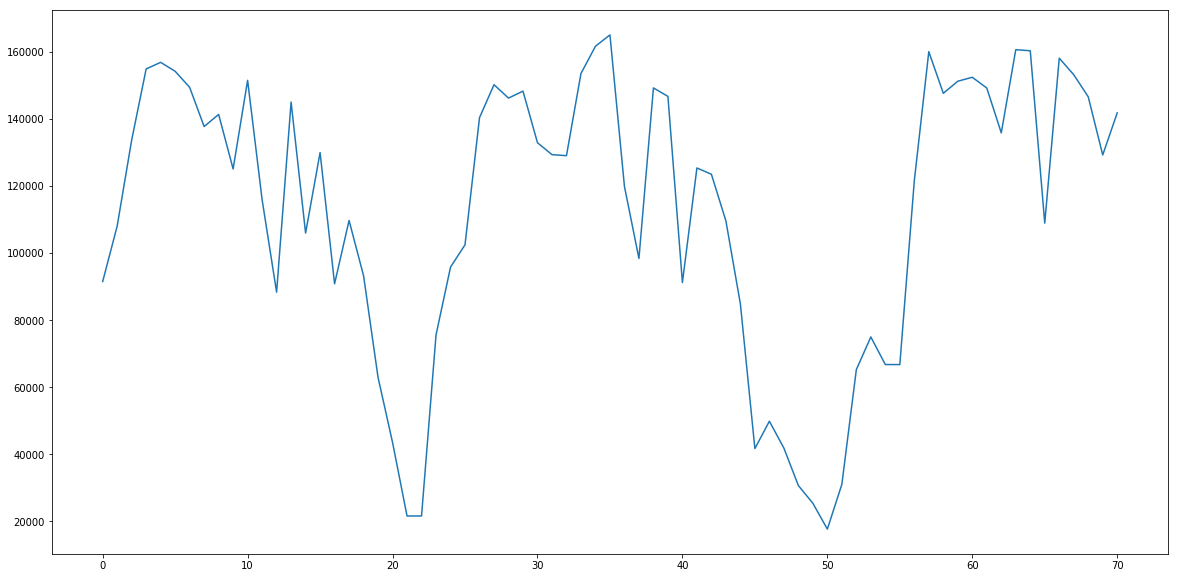

In [10]:
plt.figure(figsize=(20,10))
x = range(0,71)
plt.plot(x,green_df["x6144-y5120"].values)
plt.show()

In [11]:
train_y = green_df["x6144-y5120"].values

In [12]:
# collecting variables for this train_y

# output csv for futher processing 

# 71 days in total 
# for each day, need to calculate total pixel number that are green - total sugacrane area 

tile_x, tile_y = 6144, 5120
mask_file_path = f"./Phase02-DataDelivery/masks/mask-x{tile_x}-y{tile_y}.png"
img = Image.open(mask_file_path)
pixels = img.load()

mask_list = get_mask_list(pixels)

# get tci_dict
band_img = get_timeseries_image_paths(tile_x, tile_y, "TCI")
image_path_dict = get_image_path_dict(band_img)
tci_dict = get_tci_dict(image_path_dict, mask_list)

green_sum = [0] * 71

total_red_list = [0] * 71
total_blue_list = [0] * 71
total_green_list = [0] * 71

for i in tqdm(range(0, len(mask_list))):
    # run over 184676 mask pixels 
    
    color_dict = which_pixel_over_timeseries(i, tci_dict)
    red_list = color_dict["red_list"]    # len = 71
    green_list = color_dict["green_list"]
    blue_list = color_dict["blue_list"]
    
    # if encounter cloud, then use adjacent color. (the previous image or the next image)
    cloud_list = []
    for j in range(0,71):
        r = red_list[j]
        g = green_list[j]
        b = blue_list[j]
        if is_white_pixel(r,g,b) or is_blue_pixel(r,g,b):
            cloud_list.append(j)
    
    for key,value in color_dict.items():
        for k in cloud_list:
            if k == 0:
                kk = k + 1
                while kk in cloud_list:
                    kk += 1
                    if kk == len(value):
                        break
                value[k] = value[kk]
            else:
                kk = k - 1
                while kk in cloud_list:
                    kk -= 1
                    if kk == 0:
                        break
                value[k] = value[kk]
    
    # len(red_list) should be still 71
    red_list = color_dict["red_list"]
    green_list = color_dict["green_list"]
    blue_list = color_dict["blue_list"]
    
    total_red_list = list( map(add, total_red_list, red_list) )
    total_green_list = list( map(add, total_green_list, green_list) )
    total_blue_list = list( map(add, total_blue_list, blue_list) )
    
    


In [13]:
n_pixels = len(mask_list)
mean_red_list = [x / n_pixels for x in total_red_list]
mean_green_list = [x / n_pixels for x in total_green_list]
mean_blue_list = [x / n_pixels for x in total_blue_list]

In [14]:
train_df = pd.DataFrame( {"mean_red_list":mean_red_list, "mean_green_list":mean_green_list, \
                          "mean_blue_list":mean_blue_list, "green_sum":train_y})




In [15]:
train_df.head()
# need to include time 

,mean_red_list,mean_green_list,mean_blue_list,green_sum
0,94.205371,100.994390,105.653737,91481
1,89.756954,99.390742,102.499028,108012
2,108.848463,122.662916,127.599398,133676
3,72.215260,92.650213,93.317141,154892
4,59.847201,80.524712,82.365212,156853


In [20]:
# timeseries_list

timestamp_list = []
for t in timeseries_list:
    day = datetime.strptime(t, "%Y-%m-%d")
    timestamp = datetime.timestamp(day)
    timestamp_list.append(timestamp)

In [22]:
train_df["timestamp"] = timestamp_list

In [23]:
train_df.head()

,mean_red_list,mean_green_list,mean_blue_list,green_sum,timestamp
0,94.205371,100.994390,105.653737,91481,1.482325e+09
1,89.756954,99.390742,102.499028,108012,1.483189e+09
2,108.848463,122.662916,127.599398,133676,1.484053e+09
3,72.215260,92.650213,93.317141,154892,1.486645e+09
4,59.847201,80.524712,82.365212,156853,1.487509e+09


In [24]:
# calculating deltaT

deltaT_list = []
for i in list(range(len(timestamp_list))):
    if i == len(timestamp_list) - 1:
        break
    deltaT = timestamp_list[i+1] - timestamp_list[i]
    deltaT_list.append(deltaT)


In [26]:
len(deltaT_list)
deltaT_list.insert(0, 0)

In [27]:
train_df["deltaT"] = deltaT_list

In [28]:
train_df.head()

,mean_red_list,mean_green_list,mean_blue_list,green_sum,timestamp,deltaT
0,94.205371,100.994390,105.653737,91481,1.482325e+09,0.0
1,89.756954,99.390742,102.499028,108012,1.483189e+09,864000.0
2,108.848463,122.662916,127.599398,133676,1.484053e+09,864000.0
3,72.215260,92.650213,93.317141,154892,1.486645e+09,2592000.0
4,59.847201,80.524712,82.365212,156853,1.487509e+09,864000.0


In [29]:
# formulate train df

train_df_formulated = pd.DataFrame( {"timestamp":timestamp_list, "deltaT":deltaT_list, \
               "mean_red_list":mean_red_list, "mean_green_list":mean_green_list,"mean_blue_list":mean_blue_list, \
               "green_sum":train_y})


In [30]:
train_df_formulated.head()

,timestamp,deltaT,mean_red_list,mean_green_list,mean_blue_list,green_sum
0,1.482325e+09,0.0,94.205371,100.994390,105.653737,91481
1,1.483189e+09,864000.0,89.756954,99.390742,102.499028,108012
2,1.484053e+09,864000.0,108.848463,122.662916,127.599398,133676
3,1.486645e+09,2592000.0,72.215260,92.650213,93.317141,154892
4,1.487509e+09,864000.0,59.847201,80.524712,82.365212,156853


In [30]:
# slide window class 
# reference: https://towardsdatascience.com/ml-approaches-for-time-series-4d44722e48fe

class WindowSlider(object):
    
    def __init__(self, window_size = 5):        
        '''
        Window Slider object
        ====================
        w: window_size - number of time steps to look back
        o: offset between last reading and temperature
        r: response_size - number of time steps to predict
        l: maximum length to slide - (#observation - w)
        p: final predictors - (#predictors * w)
        '''
        self.w = window_size
        self.o = 0
        self.r = 1       
        self.l = 0
        self.p = 0
        self.names = []
        
    def re_init(self, arr):
        '''
        Helper function to initializate to 0 a vector
        '''
        arr = np.cumsum(arr)
        return arr - arr[0]
                

    def collect_windows(self, X, window_size=5, offset=0, previous_y=False):
        '''
        Input: X is the input matrix, each column is a variable
        Returns: diferent mappings window-output
        '''
        cols = len(list(X)) - 1
        N = len(X)
        
        self.o = offset
        self.w = window_size
        self.l = N - (self.w + self.r) + 1 + 1
        if not previous_y: self.p = cols * (self.w)
        if previous_y: self.p = (cols + 1) * (self.w)
        
        # Create the names of the variables in the window
        # Check first if we need to create that for the response itself
        if previous_y: x = cp.deepcopy(X)
        if not previous_y: x = X.drop(X.columns[-1], axis=1)  
        
        for j, col in enumerate(list(x)):        
                
            for i in range(self.w):
                
                name = col + ('(%d)' % (i+1))
                self.names.append(name)
        
        # Incorporate the timestamps where we want to predict
        for k in range(self.r):
            
            name = '∆t' + ('(%d)' % (self.w + k + 1))
            self.names.append(name)
            
        self.names.append('Y')
                
        df = pd.DataFrame(np.zeros(shape=(self.l, (self.p + self.r + 1))), 
                          columns=self.names)
        
        # Populate by rows in the new dataframe
        for i in range(self.l):
            
            slices = np.array([])
            
            # Flatten the lags of predictors
            for p in range(x.shape[1]):
            
                line = X.values[i:self.w + i, p]
                # Reinitialization at every window for ∆T
                if p == 0: line = self.re_init(line)
                    
                # Concatenate the lines in one slice    
                slices = np.concatenate((slices, line)) 
 
            # Incorporate the timestamps where we want to predict
                
    
            line = np.array([self.re_init(X.values[i:i+self.w+self.r, 0])[-1]])
            if i == N-5:
                y = np.array(0).reshape(1,)
            else:
                y = np.array(X.values[self.w + i + self.r - 1, -1]).reshape(1,)
            slices = np.concatenate((slices, line, y))
            
            # Incorporate the slice to the cake (df)
            df.iloc[i,:] = slices
            
        return df


In [33]:
w = 5
train_constructor = WindowSlider()
train_windows = train_constructor.collect_windows(train_df_formulated.iloc[:,1:], 
                                                  previous_y=False)
train_windows.head(3)

,deltaT(1),deltaT(2),deltaT(3),deltaT(4),deltaT(5),mean_red_list(1),mean_red_list(2),mean_red_list(3),mean_red_list(4),mean_red_list(5),mean_green_list(1),mean_green_list(2),mean_green_list(3),mean_green_list(4),mean_green_list(5),mean_blue_list(1),mean_blue_list(2),mean_blue_list(3),mean_blue_list(4),mean_blue_list(5),∆t(6),Y
0,0.0,864000.0,1728000.0,4320000.0,5184000.0,94.205371,89.756954,108.848463,72.215260,59.847201,100.994390,99.390742,122.662916,92.650213,80.524712,105.653737,102.499028,127.599398,93.317141,82.365212,6048000.0,154195.0
1,0.0,864000.0,3456000.0,4320000.0,5184000.0,89.756954,108.848463,72.215260,59.847201,77.718750,99.390742,122.662916,92.650213,80.524712,98.722472,102.499028,127.599398,93.317141,82.365212,100.784763,6048000.0,149408.0
2,0.0,2592000.0,3456000.0,4320000.0,5184000.0,108.848463,72.215260,59.847201,77.718750,66.461398,122.662916,92.650213,80.524712,98.722472,85.287354,127.599398,93.317141,82.365212,100.784763,87.154163,6912000.0,137710.0


In [40]:
train_windows.tail(3)

,deltaT(1),deltaT(2),deltaT(3),deltaT(4),deltaT(5),mean_red_list(1),mean_red_list(2),mean_red_list(3),mean_red_list(4),mean_red_list(5),mean_green_list(1),mean_green_list(2),mean_green_list(3),mean_green_list(4),mean_green_list(5),mean_blue_list(1),mean_blue_list(2),mean_blue_list(3),mean_blue_list(4),mean_blue_list(5),∆t(6),Y
63,0.0,864000.0,2592000.0,3456000.0,4320000.0,47.027616,65.720500,88.437931,47.210889,50.036272,69.787013,87.640307,105.731822,69.339034,71.530997,70.467178,92.523080,114.746962,70.939682,72.607610,6048000.0,146580.0
64,0.0,1728000.0,2592000.0,3456000.0,5184000.0,65.720500,88.437931,47.210889,50.036272,55.425371,87.640307,105.731822,69.339034,71.530997,73.070310,92.523080,114.746962,70.939682,72.607610,73.188008,6048000.0,129222.0
65,0.0,864000.0,1728000.0,3456000.0,4320000.0,88.437931,47.210889,50.036272,55.425371,85.058642,105.731822,69.339034,71.530997,73.070310,98.983007,114.746962,70.939682,72.607610,73.188008,101.025263,5184000.0,141792.0


In [46]:
train_df_formulated.tail(8)

,timestamp,deltaT,mean_red_list,mean_green_list,mean_blue_list,green_sum
63,1.557497e+09,864000.0,47.027616,69.787013,70.467178,160627
64,1.558361e+09,864000.0,65.720500,87.640307,92.523080,160312
65,1.560089e+09,1728000.0,88.437931,105.731822,114.746962,108894
66,1.560953e+09,864000.0,47.210889,69.339034,70.939682,158092
67,1.561817e+09,864000.0,50.036272,71.530997,72.607610,153165
68,1.563545e+09,1728000.0,55.425371,73.070310,73.188008,146580
69,1.564409e+09,864000.0,85.058642,98.983007,101.025263,129222
70,1.565273e+09,864000.0,58.153788,74.261489,73.449463,141792


In [47]:
1.565273e+09 - 1.560089e+09

5184000.0

In [34]:
train_windows.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66 entries, 0 to 65
Data columns (total 22 columns):
deltaT(1)             66 non-null float64
deltaT(2)             66 non-null float64
deltaT(3)             66 non-null float64
deltaT(4)             66 non-null float64
deltaT(5)             66 non-null float64
mean_red_list(1)      66 non-null float64
mean_red_list(2)      66 non-null float64
mean_red_list(3)      66 non-null float64
mean_red_list(4)      66 non-null float64
mean_red_list(5)      66 non-null float64
mean_green_list(1)    66 non-null float64
mean_green_list(2)    66 non-null float64
mean_green_list(3)    66 non-null float64
mean_green_list(4)    66 non-null float64
mean_green_list(5)    66 non-null float64
mean_blue_list(1)     66 non-null float64
mean_blue_list(2)     66 non-null float64
mean_blue_list(3)     66 non-null float64
mean_blue_list(4)     66 non-null float64
mean_blue_list(5)     66 non-null float64
∆t(6)                 66 non-null float64
Y              

In [37]:
from sklearn.linear_model import LinearRegression
lr_model = LinearRegression()
lr_model.fit(train_windows.iloc[:,:-1], train_windows.iloc[:,-1])

t0 = time.time()
# lr_y = test_windows['y'].values
lr_y_fit = lr_model.predict(train_windows.iloc[:,:-1])
# lr_y_pred = lr_model.predict(test_windows.iloc[:,:-1])
tF = time.time()

# lr_residuals = lr_y_pred - lr_y
# lr_rmse = np.sqrt(np.sum(np.power(lr_residuals,2)) / len(lr_residuals))

lr_residuals = lr_y_fit - train_windows['Y'].values
lr_rmse = np.sqrt(np.sum(np.power(lr_residuals,2)) / len(lr_residuals))

print('RMSE = %.2f' % lr_rmse)
print('Time to train = %.2f seconds' % (tF - t0))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

RMSE = 18044.40
Time to train = 0.00 seconds


<Figure size 1440x720 with 0 Axes>

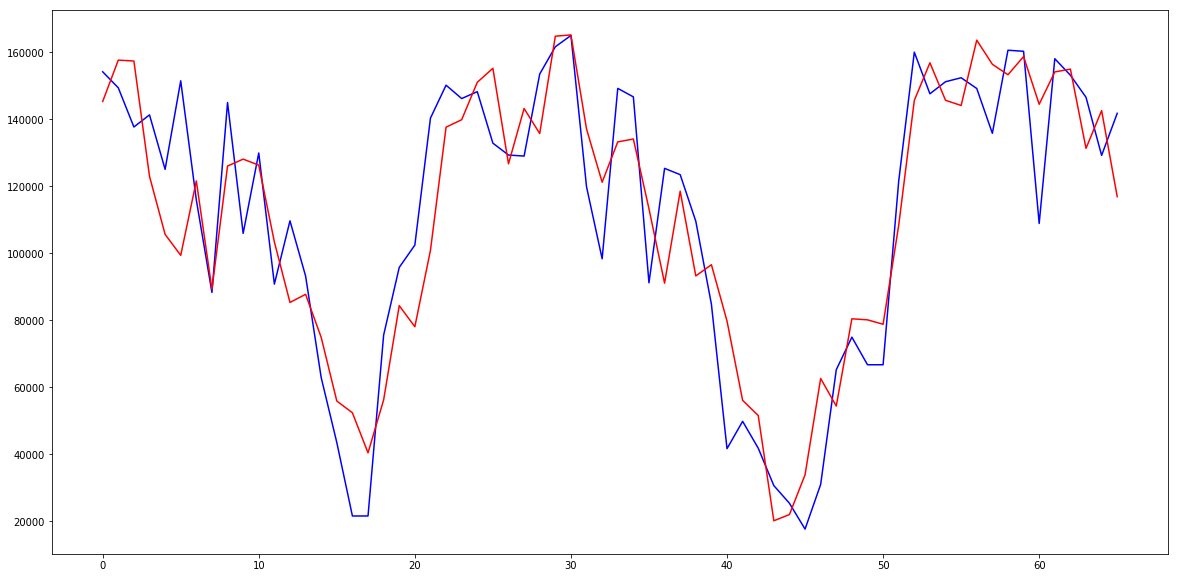

In [39]:
plt.figure(figsize=(20,10))
x = range(0, train_windows.shape[0])
plt.plot(x, train_windows['Y'].values, 'b')
plt.plot(x, lr_y_fit, 'r')
plt.show()

In [49]:
timeseries_list[-3:]

['2019-07-20', '2019-07-30', '2019-08-09']

In [65]:
# what about further prediction 

test_y = train_windows.iloc[-1,:-1].values

test_timestamp_list = []
test_time = ["2019-08-20", "2019-09-01", "2019-09-09", "2019-09-20", "2019-10-01", "2019-10-09", "2019-10-20", \
            "2019-11-01", "2019-11-09", "2019-11-20", "2019-12-01", "2019-12-09", "2019-12-20"]
for t in test_time:
    day = datetime.strptime(t, "%Y-%m-%d")
    timestamp = datetime.timestamp(day)
    test_timestamp_list.append(timestamp)


basetime = 1.560089e+09
testdelta_list = [x - basetime for x in test_timestamp_list]

In [66]:
test_df = pd.DataFrame( [test_y] * len(test_time), columns=train_windows.columns[:-1] )
test_df["∆t(6)"] = testdelta_list
test_df

,deltaT(1),deltaT(2),deltaT(3),deltaT(4),deltaT(5),mean_red_list(1),mean_red_list(2),mean_red_list(3),mean_red_list(4),mean_red_list(5),mean_green_list(1),mean_green_list(2),mean_green_list(3),mean_green_list(4),mean_green_list(5),mean_blue_list(1),mean_blue_list(2),mean_blue_list(3),mean_blue_list(4),mean_blue_list(5),∆t(6)
0,0.0,864000.0,1728000.0,3456000.0,4320000.0,88.437931,47.210889,50.036272,55.425371,85.058642,105.731822,69.339034,71.530997,73.07031,98.983007,114.746962,70.939682,72.60761,73.188008,101.025263,6134200.0
1,0.0,864000.0,1728000.0,3456000.0,4320000.0,88.437931,47.210889,50.036272,55.425371,85.058642,105.731822,69.339034,71.530997,73.07031,98.983007,114.746962,70.939682,72.60761,73.188008,101.025263,7171000.0
2,0.0,864000.0,1728000.0,3456000.0,4320000.0,88.437931,47.210889,50.036272,55.425371,85.058642,105.731822,69.339034,71.530997,73.07031,98.983007,114.746962,70.939682,72.60761,73.188008,101.025263,7862200.0
3,0.0,864000.0,1728000.0,3456000.0,4320000.0,88.437931,47.210889,50.036272,55.425371,85.058642,105.731822,69.339034,71.530997,73.07031,98.983007,114.746962,70.939682,72.60761,73.188008,101.025263,8812600.0
4,0.0,864000.0,1728000.0,3456000.0,4320000.0,88.437931,47.210889,50.036272,55.425371,85.058642,105.731822,69.339034,71.530997,73.07031,98.983007,114.746962,70.939682,72.60761,73.188008,101.025263,9763000.0
5,0.0,864000.0,1728000.0,3456000.0,4320000.0,88.437931,47.210889,50.036272,55.425371,85.058642,105.731822,69.339034,71.530997,73.07031,98.983007,114.746962,70.939682,72.60761,73.188008,101.025263,10450600.0
6,0.0,864000.0,1728000.0,3456000.0,4320000.0,88.437931,47.210889,50.036272,55.425371,85.058642,105.731822,69.339034,71.530997,73.07031,98.983007,114.746962,70.939682,72.60761,73.188008,101.025263,11401000.0
7,0.0,864000.0,1728000.0,3456000.0,4320000.0,88.437931,47.210889,50.036272,55.425371,85.058642,105.731822,69.339034,71.530997,73.07031,98.983007,114.746962,70.939682,72.60761,73.188008,101.025263,12437800.0
8,0.0,864000.0,1728000.0,3456000.0,4320000.0,88.437931,47.210889,50.036272,55.425371,85.058642,105.731822,69.339034,71.530997,73.07031,98.983007,114.746962,70.939682,72.60761,73.188008,101.025263,13129000.0
9,0.0,864000.0,1728000.0,3456000.0,4320000.0,88.437931,47.210889,50.036272,55.425371,85.058642,105.731822,69.339034,71.530997,73.07031,98.983007,114.746962,70.939682,72.60761,73.188008,101.025263,14079400.0


In [67]:
lr_y_test = lr_model.predict(test_df.iloc[:,:])

In [59]:
type(lr_y_fit)

numpy.ndarray

<Figure size 1440x720 with 0 Axes>

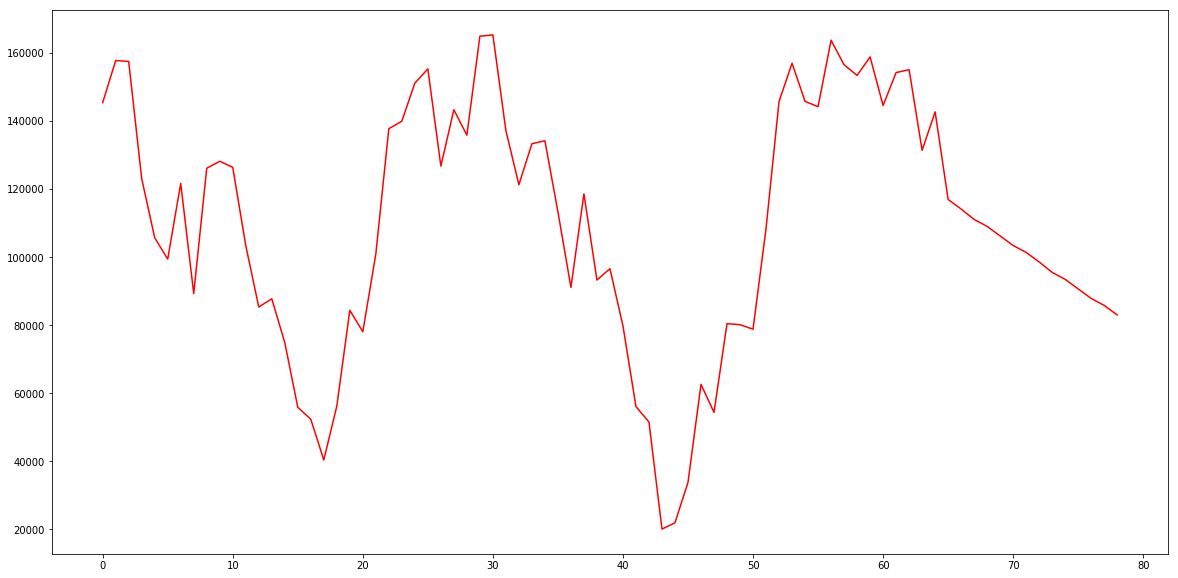

In [68]:
plt.figure(figsize=(20,10))
x = range(0, train_windows.shape[0] + len(test_time))
# plt.plot(x, train_windows['Y'].values, 'b')
plt.plot(x, np.concatenate((lr_y_fit, lr_y_test), axis=None), 'r')
plt.show()

In [5]:
total_train_df = pd.read_csv("../servercodes/timeseries_traindf.csv")
total_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170 entries, 0 to 169
Data columns (total 8 columns):
timestamp          170 non-null float64
deltaT             170 non-null float64
mean_red_list      170 non-null float64
mean_green_list    170 non-null float64
mean_blue_list     170 non-null float64
mean_nir           170 non-null float64
mean_swir          170 non-null float64
mean_ndvi          170 non-null float64
dtypes: float64(8)
memory usage: 10.7 KB


In [14]:
total_train_df = pd.read_csv("../servercodes/timeseries_traindf_with_drought.csv")
total_train_df.info()

ndvi_label = total_train_df["mean_ndvi"]
total_train_df.drop(["mean_ndvi", "temp", "rainfall"], axis=1, inplace=True)
total_train_df["mean_ndvi"] = ndvi_label

total_train_df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170 entries, 0 to 169
Data columns (total 11 columns):
timestamp          170 non-null float64
deltaT             170 non-null float64
mean_red_list      170 non-null float64
mean_green_list    170 non-null float64
mean_blue_list     170 non-null float64
mean_nir           170 non-null float64
mean_swir          170 non-null float64
mean_ndvi          170 non-null float64
temp               170 non-null float64
rainfall           170 non-null float64
drought            170 non-null int64
dtypes: float64(10), int64(1)
memory usage: 14.7 KB


,timestamp,deltaT,mean_red_list,mean_green_list,mean_blue_list,mean_nir,mean_swir,drought,mean_ndvi
0,1.482365e+09,0.0,503.880343,578.340118,362.212201,2293.081819,1857.359534,0,0.506508
1,1.483229e+09,864000.0,521.856106,611.815158,390.154601,2333.073614,1858.046619,0,0.498802
2,1.484093e+09,864000.0,496.645995,596.057661,372.699931,2333.884872,1783.302811,0,0.498219
3,1.485821e+09,1728000.0,464.077772,567.021628,342.535556,2361.285341,1726.784486,0,0.498560
4,1.487549e+09,1728000.0,431.684733,538.162458,312.545739,2388.860240,1670.441948,0,0.499630


In [31]:
w = 5
train_constructor = WindowSlider()
train_windows = train_constructor.collect_windows(total_train_df.iloc[:,1:], 
                                                  previous_y=False)
train_windows.head(3)

,deltaT(1),deltaT(2),deltaT(3),deltaT(4),deltaT(5),mean_red_list(1),mean_red_list(2),mean_red_list(3),mean_red_list(4),mean_red_list(5),mean_green_list(1),mean_green_list(2),mean_green_list(3),mean_green_list(4),mean_green_list(5),mean_blue_list(1),mean_blue_list(2),mean_blue_list(3),mean_blue_list(4),mean_blue_list(5),mean_nir(1),mean_nir(2),mean_nir(3),mean_nir(4),mean_nir(5),mean_swir(1),mean_swir(2),mean_swir(3),mean_swir(4),mean_swir(5),drought(1),drought(2),drought(3),drought(4),drought(5),∆t(6),Y
0,0.0,864000.0,1728000.0,3456000.0,5184000.0,503.880343,521.856106,496.645995,464.077772,431.684733,578.340118,611.815158,596.057661,567.021628,538.162458,362.212201,390.154601,372.699931,342.535556,312.545739,2293.081819,2333.073614,2333.884872,2361.285341,2388.860240,1857.359534,1858.046619,1783.302811,1726.784486,1670.441948,0.0,0.0,0.0,0.0,0.0,6048000.0,0.455974
1,0.0,864000.0,2592000.0,4320000.0,5184000.0,521.856106,496.645995,464.077772,431.684733,450.414438,611.815158,596.057661,567.021628,538.162458,598.956724,390.154601,372.699931,342.535556,312.545739,363.175666,2333.073614,2333.884872,2361.285341,2388.860240,2400.491361,1858.046619,1783.302811,1726.784486,1670.441948,1658.883800,0.0,0.0,0.0,0.0,0.0,6048000.0,0.433116
2,0.0,1728000.0,3456000.0,4320000.0,5184000.0,496.645995,464.077772,431.684733,450.414438,455.519439,596.057661,567.021628,538.162458,598.956724,606.126042,372.699931,342.535556,312.545739,363.175666,367.582647,2333.884872,2361.285341,2388.860240,2400.491361,2380.789335,1783.302811,1726.784486,1670.441948,1658.883800,1640.762434,0.0,0.0,0.0,0.0,0.0,6048000.0,0.414356


In [33]:
total_train_df.tail(3)

,timestamp,deltaT,mean_red_list,mean_green_list,mean_blue_list,mean_nir,mean_swir,drought,mean_ndvi
167,1.571357e+09,432000.0,810.203139,771.044065,577.546087,1979.538155,2358.440224,0,0.323458
168,1.571789e+09,432000.0,863.061690,812.306614,609.864048,2102.790868,2453.059348,0,0.339284
169,1.572221e+09,432000.0,824.264146,751.880275,534.265445,2088.163974,2449.426497,0,0.374844


In [32]:
train_windows.tail(3)

,deltaT(1),deltaT(2),deltaT(3),deltaT(4),deltaT(5),mean_red_list(1),mean_red_list(2),mean_red_list(3),mean_red_list(4),mean_red_list(5),mean_green_list(1),mean_green_list(2),mean_green_list(3),mean_green_list(4),mean_green_list(5),mean_blue_list(1),mean_blue_list(2),mean_blue_list(3),mean_blue_list(4),mean_blue_list(5),mean_nir(1),mean_nir(2),mean_nir(3),mean_nir(4),mean_nir(5),mean_swir(1),mean_swir(2),mean_swir(3),mean_swir(4),mean_swir(5),drought(1),drought(2),drought(3),drought(4),drought(5),∆t(6),Y
163,0.0,432000.0,864000.0,1296000.0,1728000.0,767.376991,790.751629,814.618862,757.762398,810.203139,720.175147,731.502172,743.322593,716.901081,771.044065,535.962398,547.839337,560.209104,529.143793,577.546087,2000.453318,1997.018941,1994.074268,1969.522296,1979.538155,2241.704532,2290.400896,2339.588795,2311.328513,2358.440224,0.0,0.0,1.0,0.0,0.0,2160000.0,0.339284
164,0.0,432000.0,864000.0,1296000.0,1728000.0,790.751629,814.618862,757.762398,810.203139,863.061690,731.502172,743.322593,716.901081,771.044065,812.306614,547.839337,560.209104,529.143793,577.546087,609.864048,1997.018941,1994.074268,1969.522296,1979.538155,2102.790868,2290.400896,2339.588795,2311.328513,2358.440224,2453.059348,0.0,1.0,0.0,0.0,0.0,2160000.0,0.374844
165,0.0,432000.0,864000.0,1296000.0,1728000.0,814.618862,757.762398,810.203139,863.061690,824.264146,743.322593,716.901081,771.044065,812.306614,751.880275,560.209104,529.143793,577.546087,609.864048,534.265445,1994.074268,1969.522296,1979.538155,2102.790868,2088.163974,2339.588795,2311.328513,2358.440224,2453.059348,2449.426497,1.0,0.0,0.0,0.0,0.0,1728000.0,0.000000


In [16]:
from sklearn.linear_model import LinearRegression
lr_model = LinearRegression()
lr_model.fit(train_windows.iloc[:,:-1], train_windows.iloc[:,-1])

t0 = time.time()
lr_y_fit = lr_model.predict(train_windows.iloc[:,:-1])
tF = time.time()


lr_residuals = lr_y_fit - train_windows['Y'].values
lr_rmse = np.sqrt(np.sum(np.power(lr_residuals,2)) / len(lr_residuals))

print('RMSE = %.2f' % lr_rmse)
print('Time to train = %.2f seconds' % (tF - t0))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

RMSE = 0.04
Time to train = 0.00 seconds


<Figure size 1440x720 with 0 Axes>

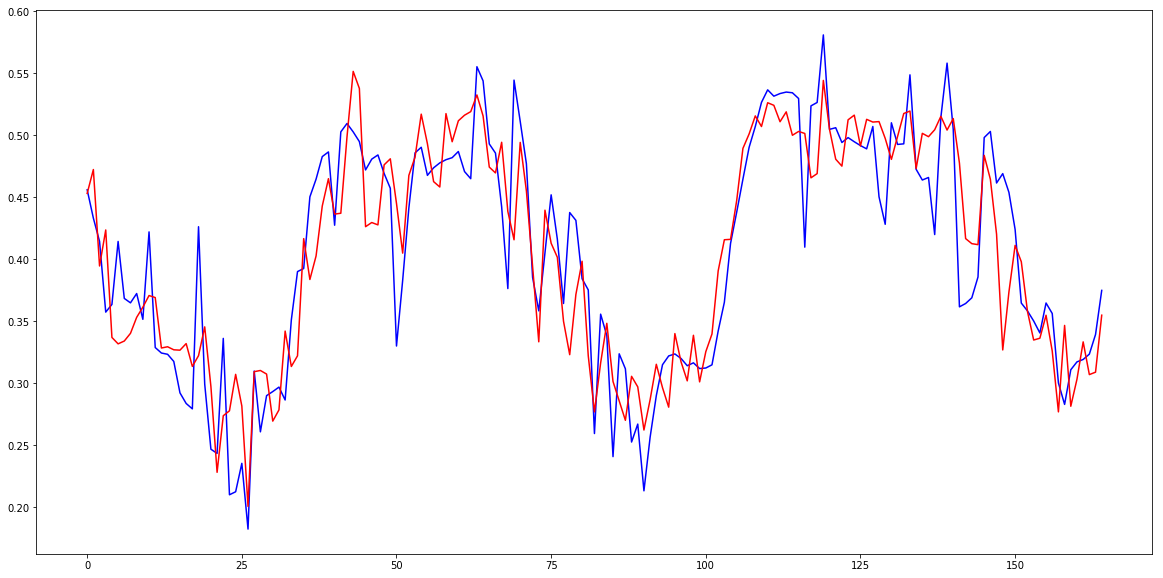

In [17]:
plt.figure(figsize=(20,10))
x = range(0, train_windows.shape[0])
plt.plot(x, train_windows['Y'].values, 'b')
plt.plot(x, lr_y_fit, 'r')
plt.show()

In [36]:
train_windows.tail(3)

,deltaT(1),deltaT(2),deltaT(3),deltaT(4),deltaT(5),mean_red_list(1),mean_red_list(2),mean_red_list(3),mean_red_list(4),mean_red_list(5),mean_green_list(1),mean_green_list(2),mean_green_list(3),mean_green_list(4),mean_green_list(5),mean_blue_list(1),mean_blue_list(2),mean_blue_list(3),mean_blue_list(4),mean_blue_list(5),mean_nir(1),mean_nir(2),mean_nir(3),mean_nir(4),mean_nir(5),mean_swir(1),mean_swir(2),mean_swir(3),mean_swir(4),mean_swir(5),drought(1),drought(2),drought(3),drought(4),drought(5),∆t(6),Y
163,0.0,432000.0,864000.0,1296000.0,1728000.0,767.376991,790.751629,814.618862,757.762398,810.203139,720.175147,731.502172,743.322593,716.901081,771.044065,535.962398,547.839337,560.209104,529.143793,577.546087,2000.453318,1997.018941,1994.074268,1969.522296,1979.538155,2241.704532,2290.400896,2339.588795,2311.328513,2358.440224,0.0,0.0,1.0,0.0,0.0,2160000.0,0.339284
164,0.0,432000.0,864000.0,1296000.0,1728000.0,790.751629,814.618862,757.762398,810.203139,863.061690,731.502172,743.322593,716.901081,771.044065,812.306614,547.839337,560.209104,529.143793,577.546087,609.864048,1997.018941,1994.074268,1969.522296,1979.538155,2102.790868,2290.400896,2339.588795,2311.328513,2358.440224,2453.059348,0.0,1.0,0.0,0.0,0.0,2160000.0,0.374844
165,0.0,432000.0,864000.0,1296000.0,1728000.0,814.618862,757.762398,810.203139,863.061690,824.264146,743.322593,716.901081,771.044065,812.306614,751.880275,560.209104,529.143793,577.546087,609.864048,534.265445,1994.074268,1969.522296,1979.538155,2102.790868,2088.163974,2339.588795,2311.328513,2358.440224,2453.059348,2449.426497,1.0,0.0,0.0,0.0,0.0,1728000.0,0.000000


In [35]:
# for prediction 

test_y = train_windows.iloc[-1,:-1].values
# test_y

t = "2019-11-05"
day = datetime.strptime(t, "%Y-%m-%d")
timestamp = datetime.timestamp(day)

basetime = total_train_df["timestamp"].values.tolist()[-1]
testdelta = timestamp - basetime

test_df = pd.DataFrame( [test_y], columns=train_windows.columns[:-1] )
test_df["∆t(6)"] = testdelta
test_df


,deltaT(1),deltaT(2),deltaT(3),deltaT(4),deltaT(5),mean_red_list(1),mean_red_list(2),mean_red_list(3),mean_red_list(4),mean_red_list(5),mean_green_list(1),mean_green_list(2),mean_green_list(3),mean_green_list(4),mean_green_list(5),mean_blue_list(1),mean_blue_list(2),mean_blue_list(3),mean_blue_list(4),mean_blue_list(5),mean_nir(1),mean_nir(2),mean_nir(3),mean_nir(4),mean_nir(5),mean_swir(1),mean_swir(2),mean_swir(3),mean_swir(4),mean_swir(5),drought(1),drought(2),drought(3),drought(4),drought(5),∆t(6)
0,0.0,432000.0,864000.0,1296000.0,1728000.0,814.618862,757.762398,810.203139,863.06169,824.264146,743.322593,716.901081,771.044065,812.306614,751.880275,560.209104,529.143793,577.546087,609.864048,534.265445,1994.074268,1969.522296,1979.538155,2102.790868,2088.163974,2339.588795,2311.328513,2358.440224,2453.059348,2449.426497,1.0,0.0,0.0,0.0,0.0,651600.0
